In [ ]:
import tensorflow as tf
from tensorflow import keras

#   패키지 설치
#   pip install tensorflow
#   pip install keras

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# (패션 MNIST)데이터 열기&분할
- 0: 티셔츠, 1: 바지, 2: 스웨터, 3: 드레스, 4: 코트
- 5: 샌들, 6: 셔츠, 7: 스니커즈, 8: 가방, 9: 부츠


In [ ]:
(xtrain_all, ytrain_all), (xtest, ytest) =\
    keras.datasets.fashion_mnist.load_data()

print( xtrain_all.shape, xtest.shape )    # (훈련/검증/테스트 입력 샘플 갯수, 너비, 높이)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


# 데이터 스케일링(정규화)

In [ ]:
xtrain_all_scaled = xtrain_all / 255.0
# xtest_scaled = xtest / 255.0

# 데이터 분할(훈련 + 검증)

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(
 
    xtrain_all_scaled, ytrain_all    # x: 특성, y: 타겟
    , test_size = 0.2       # 검증 데이터 비율(0~1)
#    , stratify = target      # 훈련 데이터 클래스 비율 = 검증 데이터 클래스 비율
    , random_state = 42    # 랜덤 시드
    )

print( xtrain.shape, xval.shape, xtest.shape )    # (훈련/검증/테스트 입력 샘플 갯수, 특성 개수)

(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)


# 심층 신경망

### 함수

In [ ]:
def model_fn(a_layer=None):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
# 층(드롭아웃)
model = model_fn(
    keras.layers.Dropout(0.3)    # 30% 드롭아웃
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = model_fn(
    keras.layers.Dropout(0.3)    # 30% 드롭아웃
    )

# model.summary()

# adam = tf.keras.optimizers.experimental.Adam(
#    learning_rate = 0.001    # 학습률
#    , beta_1 = 0.9           # 모멘텀 최적화(그레디언트 지수 감소 평균 조절값)
#    , beta_2 = 0.999         # RMSprop(그레디언트 제곱 지수 감소 평균 조절값)
#    )

# 모델 설정
model.compile(
    loss = 'sparse_categorical_crossentropy'    # 손실 함수(원-핫 인코딩 + 이진/다중 분류)
#   loss = 'binary/categorical_crossentropy'           # 손실 함수(이진/다중 분류)
    , metrics = 'accuracy'                             # 성능 지표(정확도)
#    , optimizer = adam
    , optimizer = 'adam'
    )

# 콜백
callbacks = keras.callbacks.ModelCheckpoint(
    'best-model.h5'                  # 모델
    , monitor = 'val_loss'         # 성능 지표
    , save_weights_only = False    # 전체(True: 가중치＆절편)
    , save_best_only = True        # 가장 낮은 검증 점수  
    )

# 조기 종료
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss'    # 성능 지표
    , patience = 2          # 성능 지표가 향상 되지 않는 최대 에포크 횟수
   , restore_best_weights = True    # 최적화 가중치 복원
    )

# 모델 학습(경사 하강법)
history = model.fit(
    xtrain, ytrain
    , epochs = 20
    , batch_size = 32    # 미니배치 샘플 개수(32)
    , validation_data=(xval, yval)
    , verbose = 0
    , callbacks = [callbacks, early_stopping]  # 콜백 변수
    )

print( history.history.keys() )
early_stopping.stopped_epoch  # 몇 번째 에포크에서 훈련이 중지되었는지 확인

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


12

In [ ]:
model.evaluate(xval, yval)    # 검증 데이터 - 손실 함수, 성능 지표

375/375 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.8794


[0.3255222737789154, 0.8794166445732117]

### 그래프

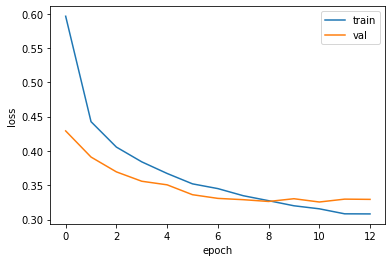

In [ ]:
# 손실
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 모델 저장

In [ ]:
# 확장자: .h5
model.save('model-whole.h5') # 전체
model.save_weights('model-weights.h5') # 가중치

In [ ]:
# 모델 확인
!ls - al *.h5

ls: cannot access '-': No such file or directory
ls: cannot access 'al': No such file or directory
best-model.h5  model-weights.h5  model-whole.h5


# 모델 불러오기

In [ ]:
model.load_weights('model-weights.h5')  # 파라미터

import numpy as np
val_labels = np.argmax(
    model.predict(xval)
    , axis = -1  # 행 최댓값
    )

np.mean(val_labels == yval)

375/375 [==============================] - 1s 1ms/step


0.8794166666666666

In [ ]:
model = keras.models.load_model('model-whole.h5')  # 전체

model.evaluate(xval, yval)    # 검증 데이터 - 손실 함수, 성능 지표

375/375 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.8794


[0.3255222737789154, 0.8794166445732117]